In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [5]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [6]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  395251
Total transactions in test dataset:  95262


## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Обязательная часть**: на большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов
6. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
7. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

In [7]:
raw_df_grouped = raw_df[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])

# aggregated_dataset = raw_df_grouped.unstack().fillna(0)
aggregated_dataset = raw_df_grouped.unstack()

In [8]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    return dataset.groupby(['cl_id','hour_of_transaction'])['hour_of_transaction'].size().unstack().fillna(0).reset_index()

In [9]:
transaction_by_day_count(raw_df)

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,9,5.0,8.0,7.0,5.0,6.0,4.0,4.0
4,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0
5,11,28.0,29.0,30.0,25.0,40.0,40.0,25.0
6,14,14.0,22.0,12.0,15.0,30.0,39.0,4.0
7,20,6.0,10.0,15.0,13.0,22.0,7.0,4.0
8,21,22.0,6.0,13.0,18.0,16.0,36.0,13.0
9,22,15.0,6.0,0.0,1.0,12.0,11.0,14.0


In [10]:
mcc_base=pd.read_excel('mss_code.xlsx')

In [11]:
mcc_base.head(5)

,code,MSS group,MSSgroup 2,cashback category,cashback
0,1,Retail Purchase,other,1,1
1,2,Retail Purchase,other,1,1
2,3,Retail Purchase,other,1,1
3,4,Retail Purchase,other,1,1
4,5,Retail Purchase,other,1,1


In [12]:
db=raw_df.merge(mcc_base, left_on='MCC', right_on='code', how='left')

In [13]:
db[db['target_flag']==1]['cashback category'].value_counts()

1.0    2377187
2.0     902069
0.0      96606
Name: cashback category, dtype: int64

In [14]:
db['PERIOD'].value_counts()

01/07/2017    594281
01/06/2017    580138
01/05/2017    505262
01/12/2016    504743
01/01/2017    498007
01/08/2017    493567
01/04/2017    465560
01/02/2017    406940
01/03/2017    369368
01/09/2017    290270
01/11/2016    223801
01/10/2017    112529
01/11/2017     52266
01/12/2017     46938
01/10/2016     36239
01/01/2018     32334
01/02/2018     26101
01/03/2018     21828
01/04/2018       297
Name: PERIOD, dtype: int64

In [15]:
db

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,day_of_transaction,code,MSS group,MSSgroup 2,cashback category,cashback
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.00,POS,0,0.0,6,5200.0,Retail Purchase,home/electronic purchase+services,2.0,1.0
1,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.00,POS,0,0.0,6,5200.0,Retail Purchase,home/electronic purchase+services,2.0,1.0
2,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.00,DEPOSIT,0,0.0,4,6011.0,Financial Institutions,Financial Institutions,0.0,0.0
3,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.00,POS,0,0.0,2,5921.0,Retail Purchase,other,1.0,1.0
4,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.00,POS,0,0.0,2,5921.0,Retail Purchase,other,1.0,1.0
5,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.00,POS,0,0.0,2,5921.0,Retail Purchase,other,1.0,1.0
6,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.00,POS,0,0.0,2,5921.0,Retail Purchase,other,1.0,1.0
7,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.00,POS,0,0.0,6,5411.0,Variety/Groc/Food Stores,food store,1.0,1.0
8,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.00,POS,0,0.0,6,5411.0,Variety/Groc/Food Stores,food store,1.0,1.0
9,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.00,POS,0,0.0,6,5411.0,Variety/Groc/Food Stores,food store,1.0,1.0


In [16]:
db['trx_category'].value_counts()

POS               5168360
DEPOSIT             21223
WD_ATM_ROS          19104
BACK_TRX            14349
WD_ATM_PARTNER       9948
CAT                  7549
C2C_IN               7306
WD_ATM_OTHER         7140
C2C_OUT              5456
CASH_ADV               34
Name: trx_category, dtype: int64

In [17]:
db['MSSgroup 2'].value_counts()

food store                           3587670
 Eating Places,Restaurants            480432
 Fast Food Res.                       330808
drug store                            224789
other                                 217035
clothes                               108613
Financial Institutions                 79686
small purchase                         53091
home/electronic purchase+services      52930
telecommunications                     30872
Auto service&parts                     19643
Transportation                         18698
children                               15780
 Utilities-electric,gas,wate           10311
taxi                                    6266
health                                  4490
 Drinking Places - Bars,Tave            3688
travelling                              3567
Entertainment                           3353
Beauty service                          2642
pet                                     1651
fitness                                 1428
education 

In [18]:
db['cashback category'].value_counts()

1.0    3811310
2.0    1298480
0.0     150206
Name: cashback category, dtype: int64

In [19]:
channels=db[['cl_id', 'channel_type']]

In [20]:
channels=channels.drop_duplicates()

In [21]:
currency=db[['cl_id', 'currency']]

In [22]:
def currency_group(col):
    if col['currency']==810:
        return 'RUB'
    else:
        return 'other'

In [23]:
currency['currency_group']=currency.apply(currency_group, axis=1)

C:\Users\volko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
currency1=pd.pivot_table(currency, values=['currency'], index=['cl_id'], columns=['currency_group'], aggfunc=lambda x: len(x))

In [25]:
currency1=currency1.fillna(0)
currency1.columns=currency1.columns.droplevel(0)
currency1['RUB%']=currency1['RUB']/(currency1['RUB']+currency1['other'])



In [26]:
currency1=currency1.reset_index()[['cl_id','RUB%']]


In [27]:
db=pd.concat([db,currency['currency_group']], axis=1)

In [28]:
category_spending=db[['cl_id', 'amount','trx_category','MSSgroup 2','currency_group']]

In [29]:
category_spending['trx_category'].value_counts()

POS               5168360
DEPOSIT             21223
WD_ATM_ROS          19104
BACK_TRX            14349
WD_ATM_PARTNER       9948
CAT                  7549
C2C_IN               7306
WD_ATM_OTHER         7140
C2C_OUT              5456
CASH_ADV               34
Name: trx_category, dtype: int64

In [30]:
def cat(col):
    if col['trx_category']=='POS':
        return col['MSSgroup 2']
    if col['trx_category']=='DEPOSIT':
        return 'DEPOSIT'
    else:
        return 'rosbank_financial_operations'

In [31]:
category_spending['category_spending']=category_spending.apply(cat,axis=1)

C:\Users\volko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
category_spending=pd.pivot_table(category_spending[category_spending['currency_group']=='RUB'], values=['amount'],index=['cl_id'], columns=['category_spending'], aggfunc=np.sum)

In [33]:
category_spending=category_spending.fillna(0)

In [34]:
category_spending.columns=category_spending.columns.droplevel(0)

In [35]:
category_spending

category_spending,"Drinking Places - Bars,Tave","Eating Places,Restaurants",Fast Food Res.,"Utilities-electric,gas,wate",Auto purchase,Auto service&parts,Beauty service,DEPOSIT,Discount stores,Entertainment,...,food store,health,home/electronic purchase+services,other,pet,rosbank_financial_operations,small purchase,taxi,telecommunications,travelling
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,20000.0,0.0,0.00,...,56868.00,0.0,10046.00,3068.00,0.0,36562.00,0.00,0.00,0.0,0.00
1,0.0,43136.00,659529.36,0.00,0.0,0.00,0.0,95000.0,0.0,8575.02,...,410408.32,0.0,0.00,2025.00,0.0,50000.00,10150.00,0.00,0.0,0.00
5,560.0,52944.00,1976.00,0.00,0.0,0.00,110.0,130000.0,0.0,4800.00,...,1264409.00,2204.0,40346.00,11526.00,6705.0,209808.38,66029.00,0.00,38400.0,10034.49
9,0.0,0.00,0.00,0.00,0.0,0.00,0.0,5000.0,0.0,0.00,...,1092.00,0.0,0.00,35718.27,0.0,831950.00,420.00,0.00,0.0,0.00
10,0.0,5104.00,16080.00,0.00,0.0,25236.47,0.0,426300.0,0.0,0.00,...,1655758.53,611.0,30078.00,141851.34,722.0,497087.88,26039.40,0.00,1600.0,0.00
11,0.0,188556.80,45224.00,0.00,0.0,92331.00,1000.0,182000.0,0.0,960.00,...,873002.66,6940.0,29195.35,57126.56,969.5,0.00,133984.00,0.00,0.0,17090.00
14,0.0,90544.00,191152.48,0.00,0.0,0.00,1900.0,0.0,0.0,640.00,...,602700.88,1800.0,133660.00,18072.00,0.0,189700.00,131600.75,0.00,14396.0,104521.00
20,0.0,48373.28,0.00,0.00,0.0,180887.98,0.0,215000.0,0.0,0.00,...,300018.92,0.0,135540.68,103561.50,0.0,0.00,25814.65,0.00,800.0,0.00
21,0.0,120640.00,38824.00,26336.10,0.0,57100.00,1000.0,112000.0,0.0,0.00,...,735049.82,0.0,165775.00,93675.82,5230.0,6778.00,88360.35,0.00,0.0,8132.00


In [36]:
category_spending['total_amount']=category_spending.sum(axis=1).values

In [37]:
category_spending=category_spending.reset_index()

In [38]:
atr_tes=[x for x in category_spending.columns[1:(len(category_spending.columns)-1)]]

In [39]:
for i in atr_tes:
    category_spending[i+'_normed']=category_spending[i]/category_spending['total_amount']

In [40]:
category_spending.head(20)

category_spending,cl_id,"Drinking Places - Bars,Tave","Eating Places,Restaurants",Fast Food Res.,"Utilities-electric,gas,wate",Auto purchase,Auto service&parts,Beauty service,DEPOSIT,Discount stores,...,food store_normed,health_normed,home/electronic purchase+services_normed,other_normed,pet_normed,rosbank_financial_operations_normed,small purchase_normed,taxi_normed,telecommunications_normed,travelling_normed
0,0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,20000.0,0.0,...,0.449393,0.000000,0.079387,0.024245,0.000000,0.288927,0.000000,0.0,0.000000,0.000000
1,1,0.0,43136.00,659529.36,0.00,0.0,0.00,0.0,95000.0,0.0,...,0.294441,0.000000,0.000000,0.001453,0.000000,0.035872,0.007282,0.0,0.000000,0.000000
2,5,560.0,52944.00,1976.00,0.00,0.0,0.00,110.0,130000.0,0.0,...,0.343613,0.000599,0.010964,0.003132,0.001822,0.057017,0.017944,0.0,0.010436,0.002727
3,9,0.0,0.00,0.00,0.00,0.0,0.00,0.0,5000.0,0.0,...,0.001249,0.000000,0.000000,0.040859,0.000000,0.951692,0.000480,0.0,0.000000,0.000000
4,10,0.0,5104.00,16080.00,0.00,0.0,25236.47,0.0,426300.0,0.0,...,0.545577,0.000201,0.009911,0.046740,0.000238,0.163792,0.008580,0.0,0.000527,0.000000
5,11,0.0,188556.80,45224.00,0.00,0.0,92331.00,1000.0,182000.0,0.0,...,0.457978,0.003641,0.015316,0.029969,0.000509,0.000000,0.070288,0.0,0.000000,0.008965
6,14,0.0,90544.00,191152.48,0.00,0.0,0.00,1900.0,0.0,0.0,...,0.354862,0.001060,0.078697,0.010641,0.000000,0.111693,0.077485,0.0,0.008476,0.061540
7,20,0.0,48373.28,0.00,0.00,0.0,180887.98,0.0,215000.0,0.0,...,0.290694,0.000000,0.131328,0.100343,0.000000,0.000000,0.025012,0.0,0.000775,0.000000
8,21,0.0,120640.00,38824.00,26336.10,0.0,57100.00,1000.0,112000.0,0.0,...,0.486587,0.000000,0.109739,0.062011,0.003462,0.004487,0.058493,0.0,0.000000,0.005383
9,22,0.0,0.00,0.00,0.00,0.0,0.00,0.0,122600.0,0.0,...,0.257843,0.000000,0.000000,0.220036,0.000000,0.070838,0.025557,0.0,0.000000,0.000000


In [41]:
days=transaction_by_day_count(raw_df)

In [42]:
days['quantity']=days.sum(axis=1)-days['cl_id']

In [43]:
days['weekend']=days['day_5']+days['day_6']

In [44]:
days['others']=days['quantity']-days['weekend']

In [45]:
days['weekend_norm']=days['weekend']/days['quantity']
days['others_norm']=1-days['weekend_norm']

In [46]:
days

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6,quantity,weekend,others,weekend_norm,others_norm
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,3.0,0.400000,0.600000
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0,104.0,25.0,79.0,0.240385,0.759615
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0,142.0,49.0,93.0,0.345070,0.654930
3,9,5.0,8.0,7.0,5.0,6.0,4.0,4.0,39.0,8.0,31.0,0.205128,0.794872
4,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0,463.0,159.0,304.0,0.343413,0.656587
5,11,28.0,29.0,30.0,25.0,40.0,40.0,25.0,217.0,65.0,152.0,0.299539,0.700461
6,14,14.0,22.0,12.0,15.0,30.0,39.0,4.0,136.0,43.0,93.0,0.316176,0.683824
7,20,6.0,10.0,15.0,13.0,22.0,7.0,4.0,77.0,11.0,66.0,0.142857,0.857143
8,21,22.0,6.0,13.0,18.0,16.0,36.0,13.0,124.0,49.0,75.0,0.395161,0.604839
9,22,15.0,6.0,0.0,1.0,12.0,11.0,14.0,59.0,25.0,34.0,0.423729,0.576271


In [47]:
cashback=db[['cl_id','cashback category']]

In [48]:
cashback.head(5)

,cl_id,cashback category
0,0,2.0
1,0,2.0
2,0,0.0
3,0,1.0
4,0,1.0


In [49]:
cashback1=pd.pivot_table(cashback, values=['cl_id'], index=['cl_id'], columns=['cashback category'], aggfunc=lambda x: len(x))
cashback1=cashback1.fillna(0)

In [50]:
cashback1['total_cb']=cashback1.sum(axis=1)

In [51]:
cashback1['cat 0_norm']=cashback1[cashback1.columns[0]]/cashback1['total_cb']

In [52]:
cashback1['cat 1_norm']=cashback1[cashback1.columns[1]]/cashback1['total_cb']

In [53]:
cashback1['cat 2_norm']=cashback1[cashback1.columns[2]]/cashback1['total_cb']

In [54]:
cashback1=cashback1.reset_index()
cashback1.head(5)

cashback category,cl_id,0.0,1.0,2.0,total_cb,cat 0_norm,cat 1_norm,cat 2_norm
0,0,2.0,32.0,2.0,36.0,0.055556,0.888889,0.055556
1,1,5.0,405.0,700.0,1110.0,0.004505,0.364865,0.630631
2,5,73.0,1155.0,165.0,1393.0,0.052405,0.829146,0.118449
3,9,10.0,110.0,0.0,120.0,0.083333,0.916667,0.000000
4,10,103.0,3373.0,594.0,4070.0,0.025307,0.828747,0.145946


In [55]:
from datetime import datetime

In [56]:
period=db[['cl_id','PERIOD']]

In [57]:
res=[]
for i in period['PERIOD'].values:
    a=datetime.strptime(i, '%d/%m/%Y')
    res.append(a)
    

In [58]:
period['period_datetime']=res

C:\Users\volko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
period1=pd.pivot_table(period, index=['cl_id'], columns=['period_datetime'], aggfunc=lambda x:len(x))

In [60]:
period1=period1.fillna(0)

In [61]:
period1.columns=period1.columns.droplevel(0)

In [62]:
period1['total_cl']=period1.sum(axis=1)

In [63]:
for i in period1.columns[0:len(period1.columns)]:
    period1[str(i)+' share']=period1[i]/period1['total_cl']

In [64]:
period1=period1.reset_index()

In [65]:
target=db[['cl_id','target_flag']].groupby(['cl_id']).mean()

In [66]:
table=target.merge(channels, left_on='cl_id', right_on='cl_id', how='left')

In [67]:
table=table.merge(currency1, left_on='cl_id', right_on='cl_id', how='left')

In [68]:
columns_spending=[x for x in category_spending.columns if 'normed' in x]

In [69]:
columns_spending.append('cl_id')

In [70]:
table=table.merge(category_spending[columns_spending], left_on='cl_id', right_on='cl_id', how='left')

In [71]:
table=table.merge(days[['cl_id', 'others_norm']], left_on='cl_id', right_on='cl_id', how='left')

In [72]:
table=table.drop('Discount stores_normed',1)

In [73]:
table=table.merge(cashback1[['cl_id', 'cat 1_norm','cat 2_norm']], left_on='cl_id', right_on='cl_id', how='left')

In [74]:
columns_period=[x for x in period1.columns if isinstance(x,str)==True]

In [75]:
columns_period.append('cl_id')

In [76]:
columns_period

['cl_id',
 'total_cl',
 '2016-10-01 00:00:00 share',
 '2016-11-01 00:00:00 share',
 '2016-12-01 00:00:00 share',
 '2017-01-01 00:00:00 share',
 '2017-02-01 00:00:00 share',
 '2017-03-01 00:00:00 share',
 '2017-04-01 00:00:00 share',
 '2017-05-01 00:00:00 share',
 '2017-06-01 00:00:00 share',
 '2017-07-01 00:00:00 share',
 '2017-08-01 00:00:00 share',
 '2017-09-01 00:00:00 share',
 '2017-10-01 00:00:00 share',
 '2017-11-01 00:00:00 share',
 '2017-12-01 00:00:00 share',
 '2018-01-01 00:00:00 share',
 '2018-02-01 00:00:00 share',
 '2018-03-01 00:00:00 share',
 '2018-04-01 00:00:00 share',
 'total_cl share',
 'cl_id']

In [77]:
columns_period=columns_period[3:(len(columns_period))]

In [78]:
table=table.merge(period1[columns_period], left_on='cl_id', right_on='cl_id', how='left')

In [79]:
columns_period

['2016-11-01 00:00:00 share',
 '2016-12-01 00:00:00 share',
 '2017-01-01 00:00:00 share',
 '2017-02-01 00:00:00 share',
 '2017-03-01 00:00:00 share',
 '2017-04-01 00:00:00 share',
 '2017-05-01 00:00:00 share',
 '2017-06-01 00:00:00 share',
 '2017-07-01 00:00:00 share',
 '2017-08-01 00:00:00 share',
 '2017-09-01 00:00:00 share',
 '2017-10-01 00:00:00 share',
 '2017-11-01 00:00:00 share',
 '2017-12-01 00:00:00 share',
 '2018-01-01 00:00:00 share',
 '2018-02-01 00:00:00 share',
 '2018-03-01 00:00:00 share',
 '2018-04-01 00:00:00 share',
 'total_cl share',
 'cl_id']

In [80]:
table=table.drop(['total_cl share'],axis=1)

In [81]:
table.head(5)

,cl_id,target_flag,channel_type,RUB%,"Drinking Places - Bars,Tave_normed","Eating Places,Restaurants_normed",Fast Food Res._normed,"Utilities-electric,gas,wate_normed",Auto purchase_normed,Auto service&parts_normed,...,2017-07-01 00:00:00 share,2017-08-01 00:00:00 share,2017-09-01 00:00:00 share,2017-10-01 00:00:00 share,2017-11-01 00:00:00 share,2017-12-01 00:00:00 share,2018-01-01 00:00:00 share,2018-02-01 00:00:00 share,2018-03-01 00:00:00 share,2018-04-01 00:00:00 share
0,0,0,NaN,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.888889,0.0,0.111111,0.0,0.0,0.0,0.0
1,1,0,NaN,0.654054,0.000000,0.030947,0.473170,0.0,0.0,0.000000,...,0.127027,0.061261,0.581081,0.230631,0.0,0.000000,0.0,0.0,0.0,0.0
2,5,1,NaN,0.916726,0.000152,0.014388,0.000537,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,9,0,NaN,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.541667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,10,0,NaN,1.000000,0.000000,0.001682,0.005298,0.0,0.0,0.008315,...,0.292875,0.407617,0.299509,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [82]:
table['channel_type'].value_counts(dropna=False)

type1    3321
type2    1492
type4      58
type5      56
type3      48
NaN        25
Name: channel_type, dtype: int64

In [83]:
table=table.dropna()

In [84]:
table.shape

(4936, 53)

In [85]:
def get_woe_v1(table, col, target_col):
    all_good = len(table[table[target_col] == 1][col])
    all_bad = len(table[table[target_col] == 0][col])
    odds_series = (
        table[table[target_col] == 1][col].value_counts()
        /
        table[table[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    table[col + '_woe'] = table[col].apply(category_woe_dict.get)
    return table

In [86]:
get_woe_v1(table, 'channel_type', 'target_flag')

,cl_id,target_flag,channel_type,RUB%,"Drinking Places - Bars,Tave_normed","Eating Places,Restaurants_normed",Fast Food Res._normed,"Utilities-electric,gas,wate_normed",Auto purchase_normed,Auto service&parts_normed,...,2017-08-01 00:00:00 share,2017-09-01 00:00:00 share,2017-10-01 00:00:00 share,2017-11-01 00:00:00 share,2017-12-01 00:00:00 share,2018-01-01 00:00:00 share,2018-02-01 00:00:00 share,2018-03-01 00:00:00 share,2018-04-01 00:00:00 share,channel_type_woe
25,50,1,type5,0.996546,0.000000,0.166993,0.096609,0.000000,0.000000,0.000000,...,0.001727,0.955095,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
26,52,0,type5,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.068493,0.054795,0.027397,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
27,54,0,type5,1.000000,0.000000,0.000000,0.034337,0.000000,0.000000,0.007270,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
28,55,0,type5,1.000000,0.000000,0.016396,0.028365,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
29,56,1,type5,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049912,...,0.421053,0.144737,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
30,58,1,type5,0.928421,0.000000,0.096702,0.023408,0.000000,0.000000,0.000812,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
31,59,0,type5,1.000000,0.000000,0.268430,0.008632,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
32,61,1,type5,1.000000,0.000000,0.138498,0.133748,0.000000,0.000000,0.000103,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
33,63,0,type5,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
35,69,0,type5,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006993,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953


In [87]:
table=table.drop(['channel_type'],axis=1)

In [88]:
table

,cl_id,target_flag,RUB%,"Drinking Places - Bars,Tave_normed","Eating Places,Restaurants_normed",Fast Food Res._normed,"Utilities-electric,gas,wate_normed",Auto purchase_normed,Auto service&parts_normed,Beauty service_normed,...,2017-08-01 00:00:00 share,2017-09-01 00:00:00 share,2017-10-01 00:00:00 share,2017-11-01 00:00:00 share,2017-12-01 00:00:00 share,2018-01-01 00:00:00 share,2018-02-01 00:00:00 share,2018-03-01 00:00:00 share,2018-04-01 00:00:00 share,channel_type_woe
25,50,1,0.996546,0.000000,0.166993,0.096609,0.000000,0.000000,0.000000,0.000000,...,0.001727,0.955095,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
26,52,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.068493,0.054795,0.027397,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
27,54,0,1.000000,0.000000,0.000000,0.034337,0.000000,0.000000,0.007270,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
28,55,0,1.000000,0.000000,0.016396,0.028365,0.000000,0.000000,0.000000,0.003213,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
29,56,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049912,0.000000,...,0.421053,0.144737,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
30,58,1,0.928421,0.000000,0.096702,0.023408,0.000000,0.000000,0.000812,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
31,59,0,1.000000,0.000000,0.268430,0.008632,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
32,61,1,1.000000,0.000000,0.138498,0.133748,0.000000,0.000000,0.000103,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
33,63,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953
35,69,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016176,...,0.006993,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253953


In [89]:
table.describe()

,cl_id,target_flag,RUB%,"Drinking Places - Bars,Tave_normed","Eating Places,Restaurants_normed",Fast Food Res._normed,"Utilities-electric,gas,wate_normed",Auto purchase_normed,Auto service&parts_normed,Beauty service_normed,...,2017-08-01 00:00:00 share,2017-09-01 00:00:00 share,2017-10-01 00:00:00 share,2017-11-01 00:00:00 share,2017-12-01 00:00:00 share,2018-01-01 00:00:00 share,2018-02-01 00:00:00 share,2018-03-01 00:00:00 share,2018-04-01 00:00:00 share,channel_type_woe
count,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,...,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000
mean,5140.205632,0.556726,0.973630,0.000622,0.052128,0.019011,0.004194,0.001339,0.006953,0.001004,...,0.081118,0.048765,0.023892,0.012064,0.010212,0.006502,0.006846,0.008539,0.000247,0.080813
std,2965.044884,0.496822,0.107444,0.006832,0.097650,0.040825,0.026945,0.015682,0.033845,0.005438,...,0.163938,0.130196,0.097596,0.070456,0.066557,0.052104,0.056113,0.078183,0.010039,0.862466
min,50.000000,0.000000,0.003367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.509898
25%,2580.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.509898
50%,5125.000000,1.000000,1.000000,0.000000,0.010478,0.005541,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.509898
75%,7745.250000,1.000000,1.000000,0.000000,0.063574,0.023108,0.000000,0.000000,0.002137,0.000000,...,0.051157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.375106
max,10215.000000,1.000000,1.000000,0.261084,1.000000,1.000000,0.998879,0.441745,0.969114,0.149114,...,1.000000,1.000000,1.000000,1.000000,0.948738,1.000000,1.000000,1.000000,0.651163,1.375106


In [90]:
corr = table.corr()['target_flag']

In [91]:
corr

cl_id                                      -0.401582
target_flag                                 1.000000
RUB%                                       -0.030940
 Drinking Places - Bars,Tave_normed        -0.016188
 Eating Places,Restaurants_normed           0.104873
 Fast Food Res._normed                      0.098787
 Utilities-electric,gas,wate_normed         0.054729
Auto purchase_normed                       -0.015274
Auto service&parts_normed                  -0.037223
Beauty service_normed                       0.051285
DEPOSIT_normed                             -0.121461
Entertainment_normed                        0.025692
Entertainment (Art)_normed                 -0.001384
Financial Institutions_normed              -0.002089
Transportation_normed                       0.026893
charity_normed                              0.017842
children_normed                             0.003170
clothes_normed                              0.120970
drug store_normed                           0.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216A109D198>,
      dtype=object)

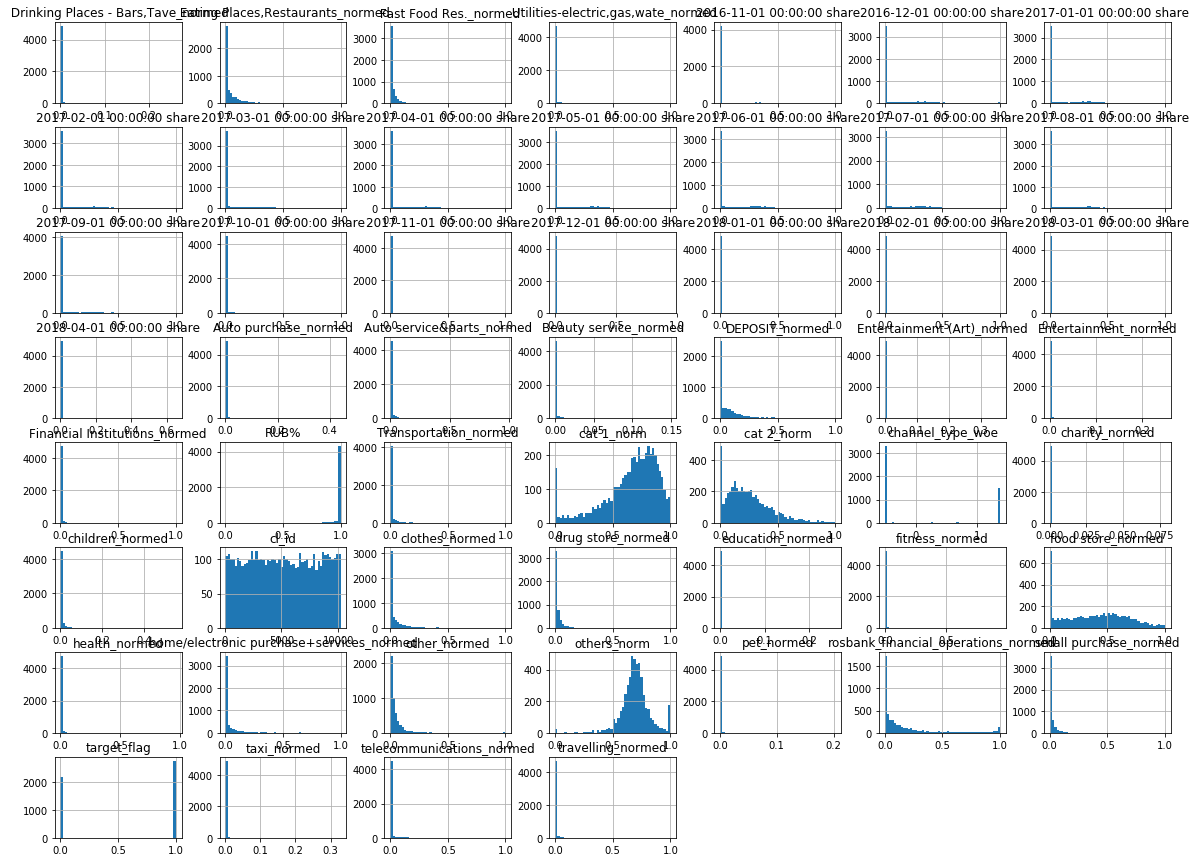

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
table.hist(bins=50, figsize=(20,15))

In [102]:
predictors=table.copy()
predictors=predictors.drop('target_flag', axis=1)
predictors=predictors.drop('cl_id', axis=1)

In [103]:
from sklearn.linear_model import Lasso

def lasso_regression(table, predictors, alpha):
    # fit
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(predictors, table['target_flag'])
    y_pred = lassoreg.predict(predictors)
    
    # format
    rss = sum((y_pred-table['target_flag']) ** 2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

In [104]:
res3 =[]
for i in predictors.columns:
    res3.append(i)
print (res3)


['RUB%', ' Drinking Places - Bars,Tave_normed', ' Eating Places,Restaurants_normed', ' Fast Food Res._normed', ' Utilities-electric,gas,wate_normed', 'Auto purchase_normed', 'Auto service&parts_normed', 'Beauty service_normed', 'DEPOSIT_normed', 'Entertainment_normed', 'Entertainment (Art)_normed', 'Financial Institutions_normed', 'Transportation_normed', 'charity_normed', 'children_normed', 'clothes_normed', 'drug store_normed', 'education_normed', 'fitness_normed', 'food store_normed', 'health_normed', 'home/electronic purchase+services_normed', 'other_normed', 'pet_normed', 'rosbank_financial_operations_normed', 'small purchase_normed', 'taxi_normed', 'telecommunications_normed', 'travelling_normed', 'others_norm', 'cat 1_norm', 'cat 2_norm', '2016-11-01 00:00:00 share', '2016-12-01 00:00:00 share', '2017-01-01 00:00:00 share', '2017-02-01 00:00:00 share', '2017-03-01 00:00:00 share', '2017-04-01 00:00:00 share', '2017-05-01 00:00:00 share', '2017-06-01 00:00:00 share', '2017-07-01 

In [105]:
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

# create dataframe to store coefficients
col = ['rss', 'intercept'] + res3
ind = ['alpha_%.2g' % alpha_lasso[i] for i in range(0, 10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i, ] = lasso_regression(table, predictors, alpha_lasso[i])

C:\Users\volko\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [122]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso.head(5).values
coef_matrix_lasso.ix[4]

C:\Users\volko\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


rss                                         9.9e+02
intercept                                      0.29
RUB%                                             -0
 Drinking Places - Bars,Tave_normed              -0
 Eating Places,Restaurants_normed              0.15
 Fast Food Res._normed                         0.24
 Utilities-electric,gas,wate_normed            0.36
Auto purchase_normed                             -0
Auto service&parts_normed                    -0.094
Beauty service_normed                           1.1
DEPOSIT_normed                                   -0
Entertainment_normed                           0.39
Entertainment (Art)_normed                       -0
Financial Institutions_normed                 0.013
Transportation_normed                          0.11
charity_normed                                  3.6
children_normed                                  -0
clothes_normed                                 0.33
drug store_normed                                 0
education_no

In [107]:
from sklearn.decomposition import PCA
pca = PCA(n_components=predictors.shape[1]).fit(predictors)
for i in range(1, predictors.shape[1] + 1):
    print("n-components=%s, explained variance %.3f" % (i, sum(pca.explained_variance_ratio_[:i])))

n-components=1, explained variance 0.512
n-components=2, explained variance 0.605
n-components=3, explained variance 0.659
n-components=4, explained variance 0.705
n-components=5, explained variance 0.745
n-components=6, explained variance 0.774
n-components=7, explained variance 0.799
n-components=8, explained variance 0.820
n-components=9, explained variance 0.835
n-components=10, explained variance 0.850
n-components=11, explained variance 0.863
n-components=12, explained variance 0.875
n-components=13, explained variance 0.887
n-components=14, explained variance 0.899
n-components=15, explained variance 0.909
n-components=16, explained variance 0.919
n-components=17, explained variance 0.929
n-components=18, explained variance 0.938
n-components=19, explained variance 0.945
n-components=20, explained variance 0.952
n-components=21, explained variance 0.958
n-components=22, explained variance 0.965
n-components=23, explained variance 0.970
n-components=24, explained variance 0.975
n

In [123]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(predictors, table['target_flag'])
y_predict=model.predict(predictors)
score_1=model.score(predictors,table['target_flag'])
print(score_1)

0.6760534846029174


In [109]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = np.round(roc_auc_score(table['target_flag'], y_predict), 2)

In [110]:
roc_auc

0.68

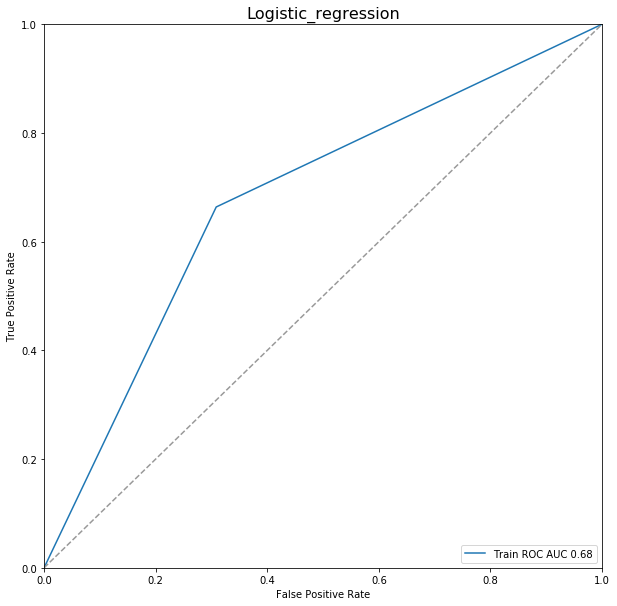

In [126]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(table['target_flag'], y_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic_regression', size=16)
plt.legend(loc='lower right')
plt.show()

ps разделить на трейн/тест, лин регресиия, еще 1 метод, комментарии